# DALI expressions and arithmetic operators

In this example, we will see how to use arithmetic operators in DALI Pipeline.

In [1]:
from __future__ import division
import types
import collections
import numpy as np
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
from nvidia.dali.types import Constant

batch_size = 1

### Defining the iterator

We will use custom iterator producing small tensors filled with series of numbers, so we can easily inspect the results.

In [2]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, left_type, right_type):
        self.batch_size = batch_size
        self.left_type = left_type
        self.right_type = right_type

    def __iter__(self):
        self.i = 0
        self.n = 128
        return self

    def __next__(self):
        left = []
        right = []
        for sample in range(self.batch_size):
            left.append(np.array([sample + self.i], dtype = self.left_type))
            right.append(np.array([self.batch_size + self.i + sample], dtype = self.right_type))
        self.i = (self.i + 1) % self.n
        return (left, right)
    
    next = __next__

### Instantiating the iterators

We create instances of the `ExternalInputIterator` with different type combinations. Type promotions for binary operators are described below. They apply to `+`, `-`, `*` and `//`. The `/` always returns a float32 for integer inputs, and applies the rules below when at least one of the inputs is a floating point number.

```
  T      op T      = T
  floatX op T      = floatX           (where T is not a float)
  floatX op floatY = float(max(X, Y))
  intX   op intY   = int(max(X, Y))
  uintX  op uintY  = uint(max(X, Y))
  intX   op uintY  = int2Y            (if X <= Y)
  intX   op uintY  = intX             (if X > Y)
 ```

In [3]:
iterator_u8_u8 = iter(ExternalInputIterator(batch_size, np.uint8, np.uint8))
iterator_u8_i32 = iter(ExternalInputIterator(batch_size, np.uint8, np.int32))
iterator_i16_u8 = iter(ExternalInputIterator(batch_size, np.int16, np.uint8))
iterator_i32_f32 = iter(ExternalInputIterator(batch_size, np.int32, np.float32))

### Defining the pipeline

The next step is to define the Pipeline.

We override `Pipeline.iter_setup`, a method called by the pipeline before every `Pipeline.run`, to call the iterator
and feed the result to `ExternalSource()` operators, referenced by `self.left` and `self.right`, by using `feed_input`.

Note, that we do not need to instantiate any additional operators, we can use regular Python arithmetic expression on the results of other operators in the `define_graph` step.

Here we return both of the inputs and the result of `self.right + self.right * self.left`. 

In [4]:
 class ExternalSourcePipeline(Pipeline):                   
    def __init__(self, iterator, batch_size, num_threads, device_id):
        super(ExternalSourcePipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.left_source = ops.ExternalSource()
        self.right_source = ops.ExternalSource()
        self.iterator = iterator

    def define_graph(self):                                                                
        self.left = self.left_source()
        self.right = self.right_source()
        return self.left, self.right, self.right + Constant(100).uint8()

    def iter_setup(self):
        (l, r) = self.iterator.next()
        self.feed_input(self.left, l)
        self.feed_input(self.right, r)

### Using the pipeline

In [5]:
for it in [iterator_u8_u8, iterator_u8_i32, iterator_i16_u8, iterator_i32_f32]:
    pipe = ExternalSourcePipeline(it, batch_size=batch_size, num_threads=2, device_id = 0)
    pipe.build()                                                        
    pipe_out = pipe.run()
    l = pipe_out[0].as_array()
    r = pipe_out[1].as_array()
    out = pipe_out[2].as_array()
    print("{} + 1 = {} of type {}".format(r, out, out.dtype))

[[1]] + 1 = [[101]] of type uint8
[[1]] + 1 = [[101]] of type int32
[[1]] + 1 = [[101]] of type uint8
[[1.]] + 1 = [[101.]] of type float32


### Image examples

Lets define a pipeline that will load some images

In [6]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
from nvidia.dali.types import Constant
import matplotlib.pyplot as plt

batch_size = 1
dogs = "images/dog"
cats = "images/kitten"

class BlendPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(BlendPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input_dogs = ops.FileReader(device="cpu", file_root="../images", file_list="dogs.txt")
        self.input_cats = ops.FileReader(device="cpu", file_root="../images", file_list="cats.txt")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.resize = ops.Resize(resize_x=400, resize_y=400)
        self.uint8 = ops.Cast(dtype=types.DALIDataType.UINT8)
        self.int16 = ops.Cast(dtype=types.DALIDataType.INT16)

    def define_graph(self):
        dogs_buf, _ = self.input_dogs()
        cats_buf, _ = self.input_cats()
        images = self.decode([dogs_buf, cats_buf])
        dogs, cats = self.resize(images)
        result = dogs * (255 / cats)
        dogs_i16 = self.int16(dogs)
        return dogs, cats, self.uint8(result), dogs_i16

In [29]:
def display(output, cpu = True):
    data_idx = 0
    fig, axes = plt.subplots(1, len(output), figsize=(15, 15))
    if len(output) == 1:
        axes = [axes]
    for i, out in enumerate(output):
        img = out.at(data_idx) if cpu else out.as_cpu().at(data_idx)
        axes[i].imshow(img / 255.0);

In [8]:
pipe = BlendPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()

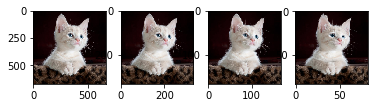

In [49]:
output = pipe.run()
display(output)

In [85]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
from nvidia.dali.types import Constant
import matplotlib.pyplot as plt

batch_size = 4

class ResizePipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(ResizePipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root="../images")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.shape_x = ops.Shapes(axes=[0])
        self.shape_y = ops.Shapes(axes=[1])
        self.resize = ops.Resize()
        self.uint8 = ops.Cast(dtype=types.DALIDataType.UINT8)

    def define_graph(self):
        input, _ = self.input()
        imgs = self.decode(input)
        x = self.shape_x(imgs)
        y = self.shape_x(imgs)
        output = []
        for divider in [1, 1.5, 2, 2.5]:
            target_x = x / divider
            target_y = y / divider
            resized = self.resize(imgs, resize_x=target_x, resize_y=target_y)
            output.append(self.uint8(resized))
        return output

In [86]:
pipe = ResizePipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()

In [87]:
# def display_batch(output, cpu = True):
#     for data_idx in range(batch_size):
#         fig, axes = plt.subplots(batch_size, len(output))
#         if len(output) == 1:
#             axes = [axes]
#         for i, out in enumerate(output):
#             img = out.at(data_idx) if cpu else out.as_cpu().at(data_idx)
#             axes[i][data_idx].imshow(img / 255.0);

def display_batch(output, cpu = True):
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 15))
    for data_idx in range(batch_size):
        if batch_size == 1:
            axes = [axes]
        img = output.at(data_idx) if cpu else out.as_cpu().at(data_idx)
        axes[data_idx].set_xlim(0, 512)
        axes[data_idx].set_ylim(512, 0)
        axes[data_idx].imshow(img)

(<nvidia.dali.backend_impl.TensorListCPU object at 0x7f2e83443b20>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7f2e81dc04c8>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7f2e81dc0848>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7f2e81dc0180>)


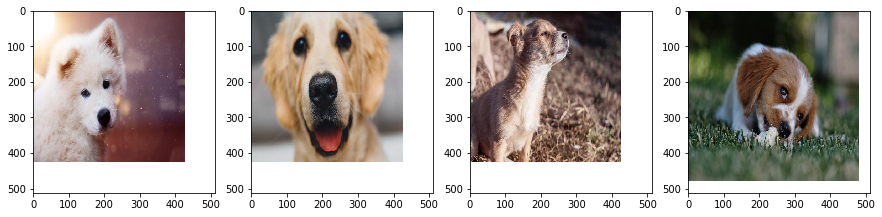

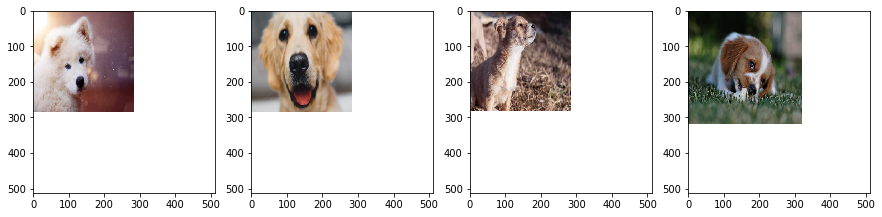

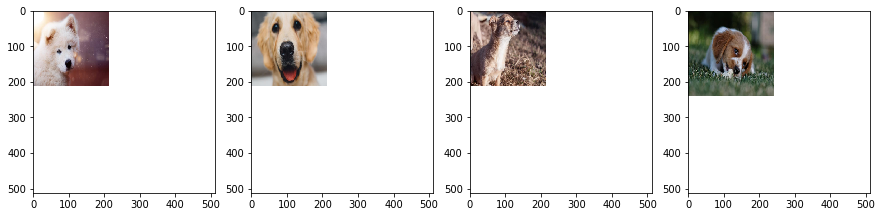

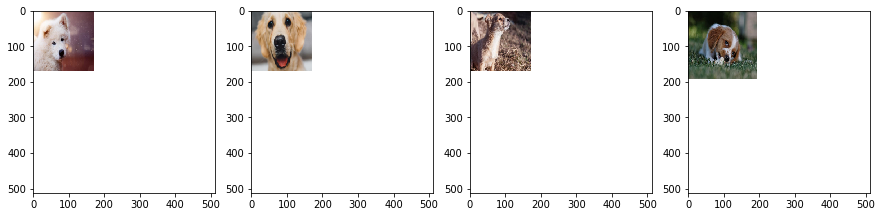

In [88]:
output = pipe.run()
print(output)
for i in range(4):
    display_batch(output[i])